<a href="https://colab.research.google.com/github/oziomaozigbo/SMCR/blob/main/Earth_Heat_2Nno4_ReTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np , matplotlib.pyplot as plt

# Earth Heat 2N

SPATIAL STRUCTURE
ao__dz = 250.0 m
Ocean depth: 3150 m
Land thickness: 8.4 m
Land fraction: 0.292
Ocean fraction: 0.708

SPATIALLY-VARYING HEAT TRANSFER COEFFICIENTS

ATMOSPHERE (convection/turbulence):
  Surface (z=0):        h = 4.83 W/(m²·K)
  Top (z=12650m): h = 1.10 W/(m²·K)
  Decay scale:          L = 5060 m

OCEAN (mixing/diffusion):
  Surface (z=0):        h = 2.01 W/(m²·K)
  Deep (z=-3150m): h = 0.21 W/(m²·K)
  Decay scale:          L = 500 m

INTERFACE:
  Ocean-Atmosphere:     h = 35.00 W/(m²·K)

Layer-by-layer breakdown:
  Atm layer | Height(m) | h_atm(W/m²K) | Density(kg/m³)
      0     |     200   |     4.83     |    1.204
      1     |     528   |     4.55     |    1.163
      2     |     864   |     4.29     |    1.122
      3     |    1415   |     3.90     |    1.058
      4     |    2318   |     3.35     |    0.961
      5     |    3797   |     2.62     |    0.821
      6     |    6219   |     1.82     |    0.634
      7     |   10187   |     1.10     |    0.416

  Ocn

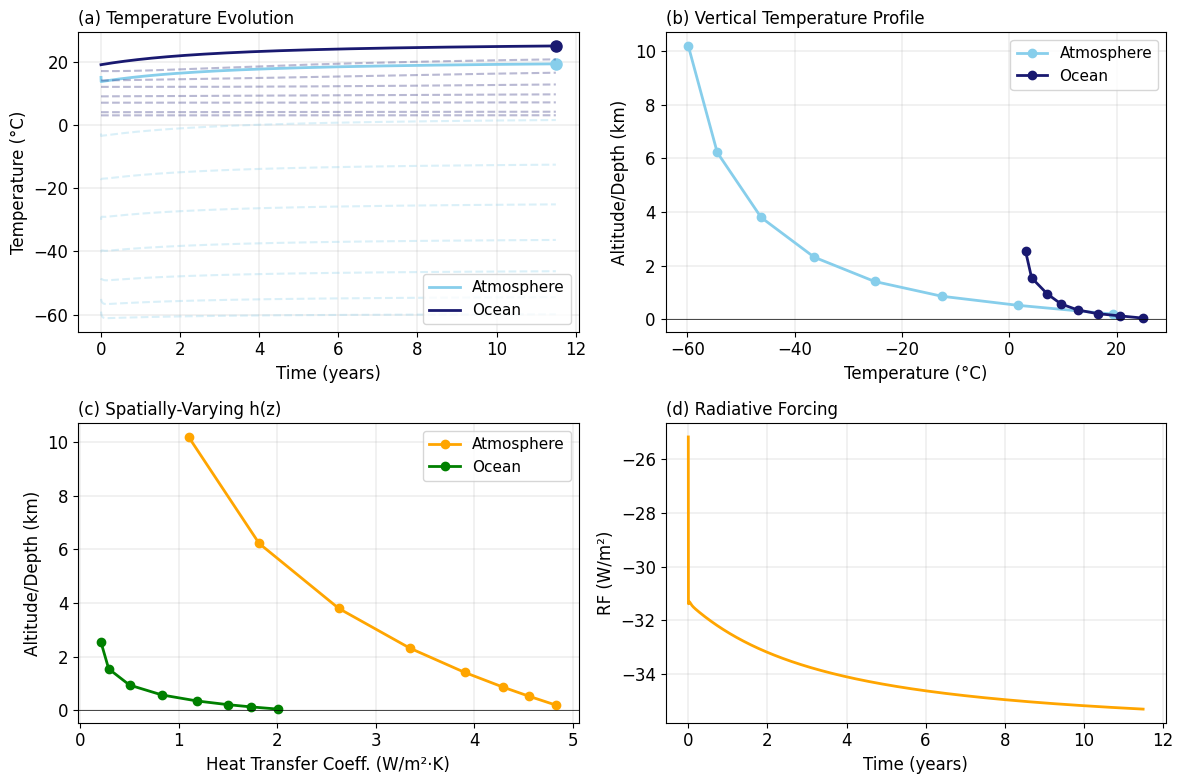

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ODE4U function (unchanged)
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    """
    time   = np.asarray(time)
    x0     = np.asarray(x0).flatten()
    points = len(time)

    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)

    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    dxdt0, y0 = odefun(time[0], x0, u[:, 0], c)

    n = x0.size
    m = np.asarray(y0).size

    x_sol = np.ones([n, points])*np.nan
    x_drv = np.ones([n, points])*np.nan
    y_sol = np.ones([m, points])*np.nan

    x_sol[:, 0] = x0
    x_drv[:, 0] = dxdt0
    y_sol[:, 0] = y0

    for p in range(points - 1):
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

        dxdt1, _ = odefun(t + dt2, x0 + dxdt0 * dt2, u_mid, c)
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt,  x0 + dxdt2 * dt, u[:, p + 1], c)

        x0 = x0 + ( dxdt0 + 2 * (dxdt1 + dxdt2) + dxdt3 ) * dt / 6.0

        dxdt0, y0 = odefun(time[p + 1], x0, u[:, p + 1], c)

        x_sol[:, p+1] = x0
        x_drv[:, p+1] = dxdt1
        y_sol[:, p+1] = y0

        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol


# Planetary constants with SPATIALLY-VARYING heat transfer coefficients
class c:
    pi  =   np.pi
    c   =  299.792458e6
    h   =    6.62607015e-34
    k   =    1.380649e-23
    sbc =    5.670367e-8        # Stefan-Boltzman constant  W/(m²·K⁴)
    Ts  = 5777.
    Rs  =    6.9570e08
    D   =    1.4960e11
    Re  =    6.3567523e6
    sec_per_yr = 365*24*3600
    aa     =  0.29              # earth albedo (tuned)
    ee_atm =  0.78              # atmos emissivity
    ee_ocn =  0.96              # ocean emissivity
    years  = 16
    n_layer = 8
    T_strat = 273 - 60
    atm_density_s = 1.23
    atm_density_t = 0.32
    atm_shc = 1003
    atm_elvtn = 12650

    # ATMOSPHERE heat transfer coefficients (spatially varying)
    # ----------------------------------------------------------
    atm_heat_transfer_surface = 5.0   # W/(m²·K) at sea level (strong convection)
    atm_heat_transfer_top = 0.5       # W/(m²·K) at tropopause (weak mixing)

    # OCEAN properties
    ocn_atm_heat_transfer = 35.0      # ocean-atmosphere interface
    ocn_shc = 4000
    ocn_density = 1023.6
    ocn_depth = 3150

    # OCEAN heat transfer coefficients (spatially varying)
    # -----------------------------------------------------
    ocn_heat_transfer_surface = 2.2   # W/(m²·K) at surface (wind-driven mixing)
    ocn_heat_transfer_deep = 0.2      # W/(m²·K) at depth (slow diffusion)

    # LAND properties
    land_thickness = 8.4
    land_area_fraction = 0.292

    # Computed constants
    solar_const = sbc*Ts**4.0 * 4*pi*Rs**2 / (4*pi*D**2.0)

    # ATMOSPHERE layer geometry
    atm_z = atm_elvtn * np.hstack([0, np.logspace(-1.5, 0.0, n_layer)])
    atm_tz = atm_z[1:n_layer+1] - atm_z[0:n_layer]
    atm_dz = 0.5*(atm_z[2:n_layer+1] - atm_z[0:n_layer-1])
    atm_z_mid = atm_z[0:n_layer] + 0.5*atm_tz  # midpoint of each layer

    # OCEAN layer geometry
    ocn_z = ocn_depth * np.hstack([0, -np.logspace(-1.5, 0.0, n_layer)])
    ocn_tz = ocn_z[0:n_layer] - ocn_z[1:n_layer+1]
    ocn_dz = 0.5*(ocn_z[0:n_layer-1] - ocn_z[2:n_layer+1])
    ocn_z_mid = ocn_z[0:n_layer] + 0.5*(ocn_z[1:n_layer+1] - ocn_z[0:n_layer])  # midpoint depths

    ao__dz = 0.5*(atm_z[1] - ocn_z[1])

    print("="*70)
    print("SPATIAL STRUCTURE")
    print("="*70)
    print(f"ao__dz = {np.round(ao__dz)} m")
    print(f"Ocean depth: {ocn_depth} m")
    print(f"Land thickness: {land_thickness} m")
    print(f"Land fraction: {land_area_fraction:.3f}")
    print(f"Ocean fraction: {1 - land_area_fraction:.3f}")

    # ATMOSPHERIC DENSITY (exponential decay with altitude)
    atm_density_decay = atm_elvtn/np.log(atm_density_s / atm_density_t)
    atm_density = atm_density_s * np.exp(-atm_z_mid/atm_density_decay)

    # ATMOSPHERIC HEAT TRANSFER COEFFICIENT (exponential decay with altitude)
    # Models: strong convection at surface, weak mixing aloft
    # h_atm(z) = h_top + (h_surface - h_top) * exp(-z / L_atm)
    atm_h_decay = atm_elvtn / 2.5  # decay scale ~5 km
    atm_heat_transfer = atm_heat_transfer_top + \
                        (atm_heat_transfer_surface - atm_heat_transfer_top) * \
                        np.exp(-atm_z_mid / atm_h_decay)

    # OCEAN HEAT TRANSFER COEFFICIENT (exponential decay with depth)
    # Models: strong wind-driven mixing in mixed layer, weak diffusion in deep ocean
    # h_ocn(z) = h_deep + (h_surface - h_deep) * exp(-|z| / L_ocn)
    ocn_h_decay = 500.0  # decay scale ~500 m (mixed layer + thermocline)
    ocn_heat_transfer = ocn_heat_transfer_deep + \
                        (ocn_heat_transfer_surface - ocn_heat_transfer_deep) * \
                        np.exp(-np.abs(ocn_z_mid) / ocn_h_decay)

    print("\n" + "="*70)
    print("SPATIALLY-VARYING HEAT TRANSFER COEFFICIENTS")
    print("="*70)
    print("\nATMOSPHERE (convection/turbulence):")
    print(f"  Surface (z=0):        h = {atm_heat_transfer[0]:.2f} W/(m²·K)")
    print(f"  Top (z={atm_elvtn}m): h = {atm_heat_transfer[-1]:.2f} W/(m²·K)")
    print(f"  Decay scale:          L = {atm_h_decay:.0f} m")
    print("\nOCEAN (mixing/diffusion):")
    print(f"  Surface (z=0):        h = {ocn_heat_transfer[0]:.2f} W/(m²·K)")
    print(f"  Deep (z=-{ocn_depth}m): h = {ocn_heat_transfer[-1]:.2f} W/(m²·K)")
    print(f"  Decay scale:          L = {ocn_h_decay:.0f} m")
    print("\nINTERFACE:")
    print(f"  Ocean-Atmosphere:     h = {ocn_atm_heat_transfer:.2f} W/(m²·K)")
    print("\nLayer-by-layer breakdown:")
    print("  Atm layer | Height(m) | h_atm(W/m²K) | Density(kg/m³)")
    for i in range(n_layer):
        print(f"     {i:2d}     | {atm_z_mid[i]:7.0f}   | {atm_heat_transfer[i]:8.2f}     | {atm_density[i]:8.3f}")
    print("\n  Ocn layer | Depth(m)  | h_ocn(W/m²K)")
    for i in range(n_layer):
        print(f"     {i:2d}     | {ocn_z_mid[i]:7.0f}   | {ocn_heat_transfer[i]:8.2f}")
    print("="*70 + "\n")
    print("TUNING TARGET: Ocean surface ~19°C, Atmosphere surface ~15°C")
    print("="*70 + "\n")

    # Area heat capacities
    atm_ahc = atm_shc * atm_density * atm_tz

    # Combined ocean/land heat capacity (area-weighted)
    ocn_ahc = ((1.0 - land_area_fraction) * ocn_shc * ocn_density * ocn_tz +
               land_area_fraction * ocn_shc * ocn_density * land_thickness)


# System dynamics with SPATIALLY-VARYING heat transfer
def sys(t, x, u, c):
    """
    State vector: x = [Q_atm, Q_ocn]
    Heat transfer coefficients now vary with altitude/depth
    """
    N = c.n_layer

    # Extract states
    Q_atm = x[0:N]
    Q_ocn = x[N:2*N]

    # Convert to temperatures
    T_atm = np.maximum(0.0, Q_atm / c.atm_ahc)
    T_ocn = np.maximum(0.0, Q_ocn / c.ocn_ahc)

    # ATMOSPHERE heat balance with SPATIALLY-VARYING h
    # =================================================
    dQ_atm_dt = np.ones(N)*np.nan

    R_out_U = c.ee_ocn * c.sbc * T_ocn[0]**4.0

    for k in range(N):
        # Lower boundary
        T_L = T_atm[k-1]
        h_L = c.atm_heat_transfer[k] if k > 0 else c.ocn_atm_heat_transfer

        if k == 0:
            T_L = T_ocn[0]
            h_L = c.ocn_atm_heat_transfer

        # Upper boundary
        if k == N-1:
            T_U = c.T_strat
            h_U = c.atm_heat_transfer[k]  # Use top layer's h
        else:
            T_U = T_atm[k+1]
            # Average h between adjacent layers
            h_U = 0.5 * (c.atm_heat_transfer[k] + c.atm_heat_transfer[k+1])

        # Radiative transfer (unchanged)
        R_in_L = R_out_U
        R_in_U = c.ee_atm * c.sbc * T_U**4.0
        R_out_L = (1-c.ee_atm) * R_in_U + c.ee_atm * c.sbc * T_atm[k]**4.0
        R_out_U = (1-c.ee_atm) * R_in_L + c.ee_atm * c.sbc * T_atm[k]**4.0

        # Total heat balance with spatially-varying h
        dQ_atm_dt[k] = R_in_L + R_in_U - R_out_L - R_out_U + \
                       h_L * (T_L - T_atm[k]) + h_U * (T_U - T_atm[k])

    # OCEAN heat balance with SPATIALLY-VARYING h
    # ============================================
    dQ_ocn_dt = np.ones(N)*np.nan

    for k in range(N):
        # Upper boundary
        T_U = T_ocn[k-1]

        if k == 0:
            T_U = T_atm[0]
            h_U = c.ocn_atm_heat_transfer

            # Surface energy balance
            u0 = u[0] - c.ee_ocn*c.sbc*T_ocn[0]**4.0 + \
                 (1-c.ee_atm)*c.sbc*T_atm[1]**4.0 + \
                 c.ee_atm*c.sbc*T_atm[0]**4.0
        else:
            # Average h between adjacent ocean layers
            h_U = 0.5 * (c.ocn_heat_transfer[k-1] + c.ocn_heat_transfer[k])
            u0 = 0

        # Lower boundary
        if k == N-1:
            h_L = 0  # No flux at bottom
            T_L = T_ocn[k]
        else:
            T_L = T_ocn[k+1]
            # Average h between adjacent layers
            h_L = 0.5 * (c.ocn_heat_transfer[k] + c.ocn_heat_transfer[k+1])

        # Total heat balance with spatially-varying h
        dQ_ocn_dt[k] = u0 + h_L * (T_L - T_ocn[k]) + h_U * (T_U - T_ocn[k])

    # Radiative forcing
    RF = c.sbc * ((1-c.ee_atm)*T_atm[1]**4.0 + c.ee_atm * T_atm[0]**4.0 - \
                  c.ee_ocn * T_ocn[0]**4.0)

    # State derivatives
    dxdt = np.hstack([dQ_atm_dt, dQ_ocn_dt])

    # Outputs
    y = np.hstack([T_atm, T_ocn, RF])

    return dxdt, y


# Run simulation
def run():
    N = c.n_layer

    # Time
    time_end = c.sec_per_yr * c.years
    time_step = c.sec_per_yr / (12*365)
    n_time = int(time_end / time_step)
    dt = time_step * np.ones(n_time)
    n_ramp = int(c.sec_per_yr * 9 / time_step)
    k_ramp = np.linspace(0, n_ramp-1, n_ramp)
    dt[0:n_ramp] = time_step * (np.sin(2*np.pi*k_ramp/n_ramp/4))**2.0
    time = np.cumsum(dt)

    print("time_step=", time_step/3600, "hr ...  number of time steps=", n_time)

    # Initial temperatures (°C)
    T_atm_init = np.array([15., -3., -17., -30., -40., -49., -55., -59.])
    T_ocn_init = np.array([19., 17., 14., 12., 9., 7., 4., 3.])

    print("T_atm_init = ", np.round(T_atm_init))
    print("T_ocn_init = ", np.round(T_ocn_init))

    # Initial heat content (convert to K)
    x_init = np.hstack([c.atm_ahc * (T_atm_init + 273),
                        c.ocn_ahc * (T_ocn_init + 273)])

    # External forcing
    u = (1 - c.aa) * (c.solar_const / 4) * np.ones(n_time)

    # Solve ODEs
    time, x, x_drv, y = ode4u(sys, time, x_init, u, c)

    time = time / c.sec_per_yr

    T_atm = y[0:N, :] - 273
    T_ocn = y[N:2*N, :] - 273
    RF = y[2*N]

    # Print results
    print("\n" + "="*70)
    print("FINAL RESULTS (Year", np.round(time[-1]), ")")
    print("="*70)
    print("Atmosphere layers (°C):")
    print("  ", np.round(T_atm[:, -1], 1))
    print("  Surface: T_atm[0] =", np.round(T_atm[0, -1], 2), "°C")
    print("\nOcean layers (°C):")
    print("  ", np.round(T_ocn[:, -1], 1))
    print("  Surface: T_ocn[0] =", np.round(T_ocn[0, -1], 2), "°C")
    print("="*70 + "\n")

    # Plotting
    fontsize = 12
    plt.rcParams['font.size'] = fontsize
    plt.ion()

    # Figure 1: Temperature evolution
    f1 = plt.figure(1, figsize=(12, 8))
    plt.clf()

    # Subplot 1: Time series
    plt.subplot(2, 2, 1)
    plt.plot(time, T_atm[0, :], "-", color='SkyBlue', linewidth=2, label="Atmosphere")
    plt.plot(time, T_ocn[0, :], "-", color='MidnightBlue', linewidth=2, label="Ocean")
    plt.plot(time[-1], T_atm[0, -1], "o", color='SkyBlue', markersize=8)
    plt.plot(time[-1], T_ocn[0, -1], "o", color='MidnightBlue', markersize=8)

    for k in range(1, N):
        plt.plot(time, T_atm[k, :], "--", color='SkyBlue', alpha=0.3)
        plt.plot(time, T_ocn[k, :], "--", color='MidnightBlue', alpha=0.3)

    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time (years)')
    plt.legend(loc='lower right', fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(a) Temperature Evolution", loc="left", fontsize=fontsize)

    # Subplot 2: Vertical profiles
    plt.subplot(2, 2, 2)
    plt.plot(T_atm[:, -1], c.atm_z_mid/1000, 'o-', color='SkyBlue', linewidth=2,
             markersize=6, label='Atmosphere')
    plt.plot(T_ocn[:, -1], -c.ocn_z_mid/1000, 'o-', color='MidnightBlue', linewidth=2,
             markersize=6, label='Ocean')
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Altitude/Depth (km)')
    plt.legend(fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(b) Vertical Temperature Profile", loc="left", fontsize=fontsize)

    # Subplot 3: Heat transfer coefficient profiles
    plt.subplot(2, 2, 3)
    plt.plot(c.atm_heat_transfer, c.atm_z_mid/1000, 'o-', color='Orange',
             linewidth=2, markersize=6, label='Atmosphere')
    plt.plot(c.ocn_heat_transfer, -c.ocn_z_mid/1000, 'o-', color='Green',
             linewidth=2, markersize=6, label='Ocean')
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Heat Transfer Coeff. (W/m²·K)')
    plt.ylabel('Altitude/Depth (km)')
    plt.legend(fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(c) Spatially-Varying h(z)", loc="left", fontsize=fontsize)

    # Subplot 4: Radiative forcing
    plt.subplot(2, 2, 4)
    plt.plot(time, RF, "-", color='Orange', linewidth=2)
    plt.ylabel('RF (W/m²)')
    plt.xlabel('Time (years)')
    plt.grid(lw=0.25)
    plt.title("(d) Radiative Forcing", loc="left", fontsize=fontsize)

    plt.tight_layout()
    plt.show()

    return time, T_atm, T_ocn


# Run the model
if __name__ == "__main__":
    print("\n" + "="*70)
    print("CLIMATE MODEL WITH SPATIALLY-VARYING HEAT TRANSFER")
    print("="*70 + "\n")
    time, T_atm, T_ocn = run()

time_step= 2.0 hr ...  number of time steps= 70080
T_atm_init =  [ 15.  -3. -17. -30. -40. -49. -55. -59.]
T_ocn_init =  [19. 17. 14. 12.  9.  7.  4.  3.]

FINAL RESULTS (Year 11.0 )
Atmosphere layers (°C):
   [ 19.3   1.5 -12.6 -25.1 -36.4 -46.2 -54.4 -59.8]
  Surface: T_atm[0] = 19.27 °C

Ocean layers (°C):
   [24.9 20.7 16.5 12.8  9.6  7.1  4.2  3. ]
  Surface: T_ocn[0] = 24.93 °C



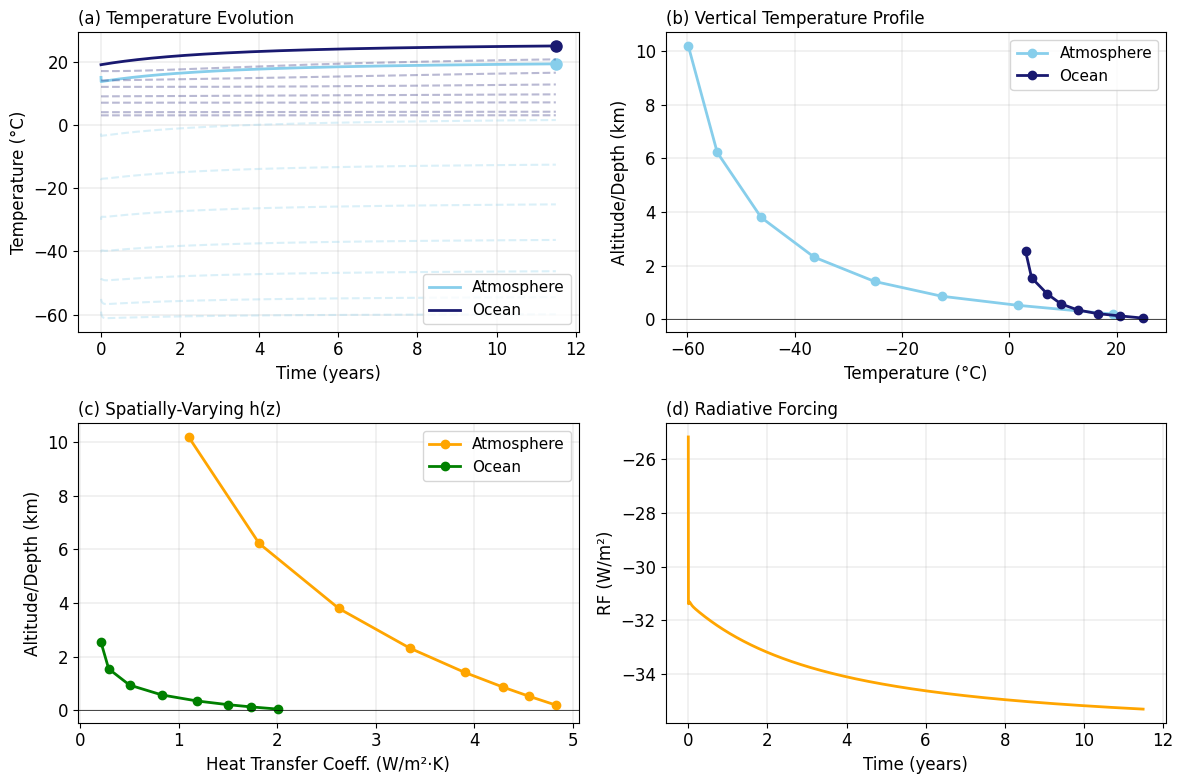

(array([0.00000000e+00, 3.62520361e-13, 1.81260180e-12, ...,
        1.14994292e+01, 1.14996575e+01, 1.14998858e+01]),
 array([[ 15.        ,  15.        ,  14.99999999, ...,  19.26714854,
          19.2671718 ,  19.26719505],
        [ -3.        ,  -3.        ,  -3.        , ...,   1.52563857,
           1.52565947,   1.52568038],
        [-17.        , -17.        , -17.        , ..., -12.57509433,
         -12.57507532, -12.57505632],
        ...,
        [-49.        , -49.        , -49.        , ..., -46.24579243,
         -46.24577983, -46.24576724],
        [-55.        , -55.        , -55.        , ..., -54.43233743,
         -54.43232782, -54.43231821],
        [-59.        , -59.        , -59.        , ..., -59.82397734,
         -59.82397187, -59.8239664 ]]),
 array([[19.        , 19.        , 19.        , ..., 24.92939633,
         24.92942091, 24.92944549],
        [17.        , 17.        , 17.        , ..., 20.6964816 ,
         20.69652221, 20.69656282],
        [14.  

In [3]:
run()